In [2]:
# 第三方库
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:

train_path = "/mnt/sdb/htzznc33/train_triplets.txt"
metadata_path = "/mnt/sdb/htzznc33/track_metadata.db"

In [4]:
# 读取数据
data = pd.read_csv(train_path, 
                   sep='\t', header=None ,names=['user', 'song', 'play_count'], nrows=5000000)
data.head(10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        object
 1   song        object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 114.4+ MB


In [6]:
# label编码
user_encoder = LabelEncoder()
data['user'] = user_encoder.fit_transform(data['user'].values)

song_encoder = LabelEncoder()
data['song'] = song_encoder.fit_transform(data['song'].values)

data = data.astype({'user': 'int32', 'song': 'int32', 'play_count': 'int32'})

In [7]:
data.head(10)


,user,song,play_count
0,75139,4268,1
1,75139,6272,1
2,75139,11321,2
3,75139,12994,1
4,75139,13008,1
5,75139,16473,1
6,75139,18579,2
7,75139,19604,1
8,75139,20341,1
9,75139,20441,1


In [8]:
# 用户播放次数
user_count = data.groupby("user")["play_count"].sum()
user_count

user
0          33
1          17
2          73
3         105
4          45
         ... 
104469     23
104470     25
104471     63
104472     53
104473     23
Name: play_count, Length: 104474, dtype: int32

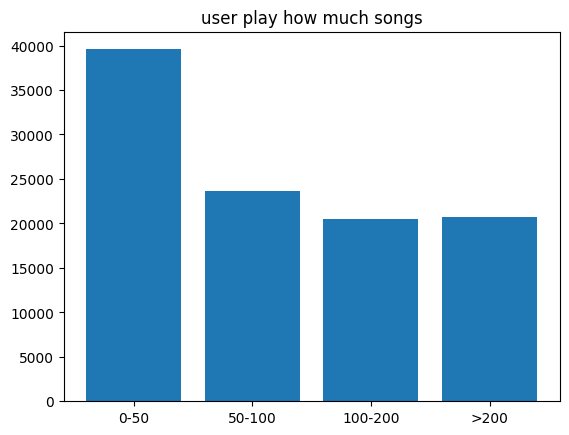

In [9]:
# 定义区间范围和标签
bins = [0, 50, 100, 200, float('inf')]
labels = ['0-50', '50-100', '100-200', '>200']

# 将和按照区间范围划分
user_count['sum_range'] = pd.cut(user_count, bins=bins, labels=labels)

# 统计每个区间的计数
bin_counts = user_count['sum_range'].value_counts().sort_index()

# 绘制区间分布条形图
plt.bar(bin_counts.index, bin_counts.values)
plt.title('user play how much songs')
# 显示图表
plt.show()

In [10]:
# 歌曲被播放次数
song_count = data.groupby("song")["play_count"].sum()
song_count = song_count.sort_values(ascending=False)
song_count

song
16710     75001
8621      67422
193802    56276
60894     42177
45561     41412
          ...  
117669        1
117661        1
117659        1
218905        1
0             1
Name: play_count, Length: 259745, dtype: int32

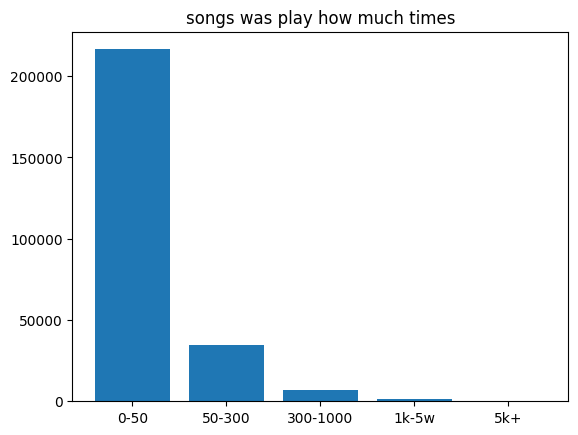

In [11]:
# 定义区间范围和标签
bins = [0, 50, 300, 1000,5000 ,float('inf')]
labels = ['0-50', '50-300', '300-1000', '1k-5w','5k+']

# 将和按照区间范围划分
user_count['sum_range'] = pd.cut(song_count, bins=bins, labels=labels)

# 统计每个区间的计数
bin_counts = user_count['sum_range'].value_counts().sort_index()

# 绘制区间分布条形图
plt.bar(bin_counts.index, bin_counts.values)
plt.title('songs was play how much times')
# 显示图表
plt.show()

/home/Shu/miniconda3/envs/torch/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


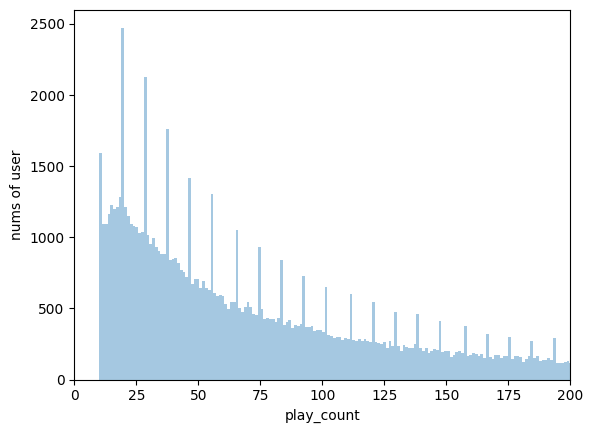

In [12]:
# 用户的歌曲播放总量的分布
# 字典user_playcounts记录每个用户的播放总量
user_playcounts = {}
for user, group in data.groupby('user'):
    user_playcounts[user] = group['play_count'].sum()
    
sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of user')
plt.show()

In [13]:


# 内存炸了  丢掉播放量少于50的歌曲
# song_playcounts字典，记录每首歌的播放量
song_playcounts = {}
for song, group in data.groupby('song'):
    song_playcounts[song] = group['play_count'].sum()
temp_song = [song for song in song_playcounts.keys() if song_playcounts[song] > 50]
temp_playcounts = [playcounts for song, playcounts in song_playcounts.items() if playcounts > 50]
data = data[data.song.isin(temp_song)]

data.info()

print(data['song'].nunique())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020055 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   user        int32
 1   song        int32
 2   play_count  int32
dtypes: int32(3)
memory usage: 76.7 MB
43220


# 处理歌曲信息文件

In [14]:
# 读取数据
conn = sqlite3.connect(metadata_path)
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

# 获得数据的dataframe
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')

In [15]:
track_metadata_df.columns


Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
      dtype='object')

In [16]:
# 对于之前的歌曲编码，我们给一个字典，对歌曲和编码进行一一映射
song_labels = dict(zip(song_encoder.classes_, range(len(song_encoder.classes_))))

# 对于那些在之前没有出现过的歌曲，我们直接给一个最大的编码
encoder = lambda x: song_labels[x] if x in song_labels.keys() else len(song_labels)

# 对数据进行labelencoder
track_metadata_df['song_id'] = track_metadata_df['song_id'].apply(encoder)

In [17]:
track_metadata_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,259745,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,259745,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,259745,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,16467,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,259745,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [18]:
track_metadata_df = track_metadata_df.rename(columns={'song_id': 'song'})
track_metadata_df.drop(['track_id', 'artist_id', 'artist_mbid', 'duration', 'track_7digitalid', 'shs_perf', 'shs_work'], axis=1, inplace=True)


In [39]:

# 根据特征song进行拼接，将拼接后的数据重新命名为data
data1 = pd.merge(data, track_metadata_df, on='song')


In [40]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416849 entries, 0 to 2416848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user                int32  
 1   song                int32  
 2   play_count          int32  
 3   rating              float64
 4   title               object 
 5   release             object 
 6   artist_name         object 
 7   artist_familiarity  float64
 8   artist_hotttnesss   float64
 9   year                int64  
dtypes: float64(3), int32(3), int64(1), object(3)
memory usage: 175.2+ MB


In [21]:
data1.drop_duplicates(inplace=True)

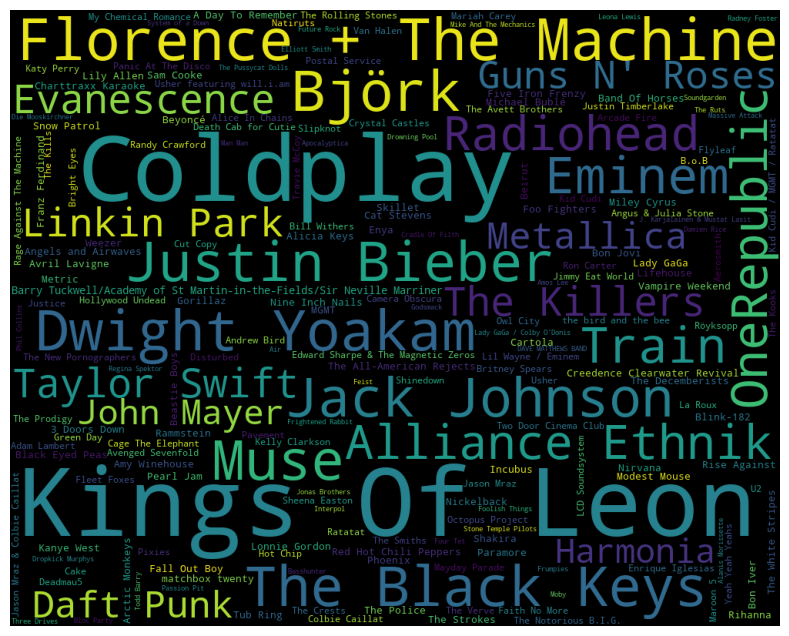

In [22]:
# 字典artist_playcounts记录每个歌手获得的点击量
artist_playcounts = {}
for artist, group in data1.groupby('artist_name'):
    artist_playcounts[artist] = group['play_count'].sum()

# 作图
plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(artist_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [23]:
(data['play_count'].min(), data['play_count'].max())

(1, 2213)

In [24]:
user_averageScore = {}
for user, group in data1.groupby('user'):
    user_averageScore[user] = group['play_count'].mean()

3.22153588592544


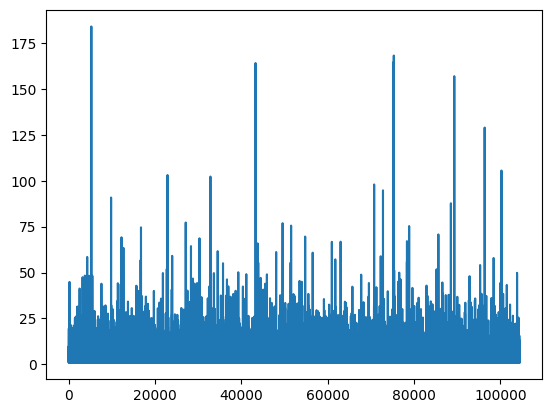

In [25]:
# from torch import sigmoid,tensor

# scores = sigmoid(tensor(list(user_averageScore.values())))*5
print(sum(list(user_averageScore.values()))/len(user_averageScore))

plt.plot(list(user_averageScore.values()))
plt.show()

In [26]:
data['rating'] = data.apply(lambda x: np.log(2 + x.play_count / user_averageScore[x.user]), axis=1)

/home/Shu/miniconda3/envs/torch/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


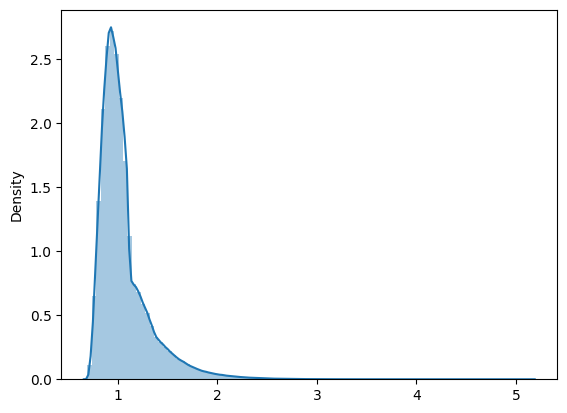

In [27]:
sns.distplot(data['rating'].values, bins=100)
plt.show()

In [28]:
max(data["rating"])

5.151049542942102

In [29]:
user_item_rating = data[['user', 'song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'song': 'item'})

In [30]:
user_item_rating.info()

user_item_rating = user_item_rating.astype({'user': 'int32', 'item': 'int32', 'rating': 'float16'})

user_item_rating.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020055 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   user    int32  
 1   item    int32  
 2   rating  float64
dtypes: float64(1), int32(2)
memory usage: 92.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020055 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   user    int32  
 1   item    int32  
 2   rating  float16
dtypes: float16(1), int32(2)
memory usage: 69.0 MB


In [31]:
# itemCF
import sys
# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)

print(sys.getsizeof(raw_data))


48


In [32]:

# 分割数据集
kf = KFold(n_splits=5)
# 构建模型
knn_itemcf = KNNBasic(k=7, sim_options={'user_based': False})
# 训练数据集，并返回rmse误差
kf.split(raw_data)
for trainset, testset in kf.split(raw_data):
    knn_itemcf.fit(trainset)
    predictions = knn_itemcf.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...


KeyboardInterrupt: 

## ItemCF预测

In [33]:
#用户听过的歌曲集合
user_songs = {}
for user, group in user_item_rating.groupby('user'):
    user_songs[user] = group['item'].values.tolist()

# 歌曲集合
songs = user_item_rating['item'].unique().tolist()

# 歌曲id和歌曲名称对应关系
songID_titles = {}
for index in data1.index:
    songID_titles[data1.loc[index, 'song']] = data1.loc[index, 'title']


In [ ]:

# itemCF 推荐
def recommendation_basedonItemCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_itemcf.predict(userID, item).est
    
    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    # song_topN = [songID_titles[s] for s in song_ids.keys()]
    song_topN = song_ids
    return song_topN




{119043: 1.6455078125000002,
 64253: 1.6455078125000002,
 238560: 1.6455078125000002,
 17500: 1.6455078125000002,
 21605: 1.6455078125000002}

In [ ]:

res = recommendation_basedonItemCF(5990,N = 10)

In [ ]:
for i,song in enumerate(res):
    print("{:>3} : {:<50},  Pre-rating: {:.6f}".format(i+1,songID_titles[song],res[song]))

  1 : New Steps / Breaking Barriers (Bonus Track)       ,  Pre-rating: 1.905273
  2 : Stretch Out                                       ,  Pre-rating: 1.905273
  3 : Rencor                                            ,  Pre-rating: 1.905273
  4 : Hideaway                                          ,  Pre-rating: 1.905273
  5 : L'interlude de Qualité                            ,  Pre-rating: 1.905273
  6 : Nothing Left To Do                                ,  Pre-rating: 1.905273
  7 : Brothers & sisters                                ,  Pre-rating: 1.905273
  8 : Lay Me Down                                       ,  Pre-rating: 1.905273
  9 : No One Seems To Care                              ,  Pre-rating: 1.905273
 10 : High Lonesome                                     ,  Pre-rating: 1.905273


## GBDT+LR

In [35]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4149459 entries, 0 to 4150710
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user                int32  
 1   song                int32  
 2   play_count          int32  
 3   title               object 
 4   release             object 
 5   artist_name         object 
 6   artist_familiarity  float64
 7   artist_hotttnesss   float64
 8   year                int64  
dtypes: float64(2), int32(3), int64(1), object(3)
memory usage: 398.1+ MB


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020055 entries, 0 to 4999999
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user        int32  
 1   song        int32  
 2   play_count  int32  
 3   rating      float64
dtypes: float64(1), int32(3)
memory usage: 107.3 MB


In [41]:
rank_data = data1.copy()

rank_data.drop("title", axis=1, inplace=True)

rating = rank_data.pop('rating')
rank_data['rating'] = rating

release_encoder = LabelEncoder()
rank_data['release'] = release_encoder.fit_transform(rank_data['release'].values)

artist_name_encoder = LabelEncoder()
rank_data['artist_name'] = artist_name_encoder.fit_transform(rank_data['artist_name'].values)

# 根据rating的取值，更新rating值
rank_data['rating'] = rank_data['rating'].apply(lambda x: 0 if x < 0.92 else 1)

rank_data.head()

,user,song,play_count,release,artist_name,artist_familiarity,artist_hotttnesss,year,rating
0,74484,2344,3,4362,2501,0.902841,1.021256,2007,1
1,87392,2344,1,4362,2501,0.902841,1.021256,2007,0
2,36920,2344,1,4362,2501,0.902841,1.021256,2007,0
3,67722,2344,3,4362,2501,0.902841,1.021256,2007,1
4,51389,2344,1,4362,2501,0.902841,1.021256,2007,0


In [42]:
rank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416849 entries, 0 to 2416848
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user                int32  
 1   song                int32  
 2   play_count          int32  
 3   release             int64  
 4   artist_name         int64  
 5   artist_familiarity  float64
 6   artist_hotttnesss   float64
 7   year                int64  
 8   rating              int64  
dtypes: float64(2), int32(3), int64(4)
memory usage: 156.7 MB


In [45]:
X_gbdt, X_lr, y_gbdt, y_lr = train_test_split(rank_data.iloc[:, :-1].values, rank_data.iloc[:, -1].values, test_size=0.3)

X_gbdt, X_lr, y_gbdt

(array([[9.76290000e+04, 8.51400000e+04, 1.00000000e+00, ...,
         9.17698884e-01, 9.08202619e-01, 2.00900000e+03],
        [4.46160000e+04, 7.10610000e+04, 1.00000000e+00, ...,
         6.66536191e-01, 4.09569489e-01, 2.00200000e+03],
        [6.51400000e+03, 8.98890000e+04, 2.00000000e+00, ...,
         8.18803869e-01, 7.59102227e-01, 2.00900000e+03],
        ...,
        [9.12280000e+04, 1.41663000e+05, 2.00000000e+00, ...,
         8.25805386e-01, 6.61382924e-01, 1.99600000e+03],
        [5.32160000e+04, 1.13990000e+05, 4.00000000e+00, ...,
         6.10481416e-01, 4.18926666e-01, 1.98600000e+03],
        [2.18100000e+04, 2.08399000e+05, 9.00000000e+00, ...,
         3.89941153e-01, 5.00514356e-01, 2.00400000e+03]]),
 array([[7.24590000e+04, 1.70124000e+05, 2.00000000e+00, ...,
         7.70493963e-01, 5.19953001e-01, 0.00000000e+00],
        [2.72260000e+04, 2.20811000e+05, 1.00000000e+00, ...,
         7.76598968e-01, 4.90079584e-01, 1.99200000e+03],
        [9.63120000e+04, 

In [177]:
depth = 6
n_estimator = 100

print('当前n_estimators=', n_estimator)
# 训练gbdt
gbdt = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, min_samples_split=3, min_samples_leaf=2)
gbdt.fit(X_gbdt, y_gbdt)

print('当前gbdt训练完成！')

# one-hot编码
onehot = OneHotEncoder()
onehot.fit(gbdt.apply(X_gbdt).reshape(-1, n_estimator))

# 对gbdt结果进行one-hot编码，然后训练lr
lr = LogisticRegression()
lr.fit(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)), y_lr)

print('当前lr训练完成！')

# 用auc作为指标
lr_pred = lr.predict(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)))
auc_score = roc_auc_score(y_lr, lr_pred)

print('当前n_estimators和auc分别为', n_estimator, auc_score)
print('#'*40)

当前n_estimators= 100
当前gbdt训练完成！


/home/Shu/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


当前lr训练完成！
当前n_estimators和auc分别为 100 0.7870411720591168
########################################


In [178]:
# 计算真正例（True Positive）数量
tp = sum([1 for p, t in zip(lr_pred, y_lr) if p == 1 and t == 1])

# 计算假正例（False Positive）数量
fp = sum([1 for p, t in zip(lr_pred, y_lr) if p == 1 and t == 0])

# 计算真负例（True Negative）数量
tn = sum([1 for p, t in zip(lr_pred, y_lr) if p == 0 and t == 0])

# 计算假负例（False Negative）数量
fn = sum([1 for p, t in zip(lr_pred, y_lr) if p == 0 and t == 1])

# 计算精确率（Precision）
precision = tp / (tp + fp)

# 计算召回率（Recall）
recall = tp / (tp + fn)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8560978748775382
Recall: 0.7984826177171652


### 去除播放量少于150的用户

In [37]:
temp_user = [user for user in user_playcounts.keys() if user_playcounts[user] > 150]
temp_playcounts = [playcounts for user, playcounts in user_playcounts.items() if playcounts > 150]

data = data[data.user.isin(temp_user)]
data1 = data1[data1.user.isin(temp_user)]
len(temp_user)

28578

In [38]:
print(len(y_lr), sum(y_lr))
print(len(lr_pred), sum(lr_pred))

NameError: name 'y_lr' is not defined